In [1]:
import pandas as pd
import numpy as np 
from nrclex import NRCLex 
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys


from Utility_Fede import aggregation, label, new_df, find_values, find_values0, count_words

#https://github.com/metalcorebear/NRCLex/blob/cda50c7d7c51709acf506b815037cb376572a629/README.md

In [2]:
#read dataframe
df = pd.read_csv ('../dataframe/dfc.csv')

In [59]:
#Carico il dizionario 
#filepath = "../dict/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
#emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')

### STEP 1 - vedere il sentimento in media nei parchi 


In [9]:
#Return affect dictionary : in ogni tweet le parole con il sentimento associato
df["emotions_dict"] = df["text1"].apply(lambda x: NRCLex(x).affect_dict) 
#Return affect frequencies
df["emotions_freq"] = df["text1"].apply(lambda x: NRCLex(x).affect_frequencies)
#Return highest emotions
df["emotions_top"] = df["text1"].apply(lambda x: NRCLex(x).top_emotions)
df.head()

,Unnamed: 0,_id,entities,conversation_id,author_id,geo,lang,attachments,public_metrics,text,...,text1,Polarity Score,Neutral Score,Negative Score,Positive Score,Sentiment,token,emotions_dict,emotions_freq,emotions_top
0,0,633029307275866112,"{'hashtags': [{'start': 22, 'end': 28, 'tag': ...",633029307275866112,1448623789,{'place_id': '54e862bb3ff2f749'},en,{'media_keys': ['3_633029305400954880']},"{'retweet_count': 2, 'reply_count': 0, 'like_c...",Adare Farm supporting #Adare in #LimerickGoing...,...,adare farm support adare limerickgoingforgold ...,0.4019,0.816,0.0,0.184,Positive,"['adare', 'farm', 'support', 'adare', 'limeric...","{'farm': ['anticipation'], 'gold': ['positive']}","{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...","[(positive, 0.5), (anticipation, 0.5)]"
1,1,1514874742750261251,"{'mentions': [{'start': 21, 'end': 36, 'userna...",1514874742750261251,93829151,{'place_id': '54e862bb3ff2f749'},en,{'media_keys': ['3_1514874728154120195']},"{'retweet_count': 7, 'reply_count': 0, 'like_c...",Adare Manor team and @adaretidytowns ready for...,...,adare manor team adaretidytown ready year team...,0.3612,0.828,0.0,0.172,Positive,"['adare', 'manor', 'team', 'adaretidytown', 'r...","{'team': ['trust'], 'ready': ['anticipation']}","{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...","[(trust, 0.6666666666666666)]"
2,2,1038675384940810240,"{'urls': [{'start': 205, 'end': 228, 'url': 'h...",1038675384940810240,1675222543,{'place_id': '54e862bb3ff2f749'},en,{'media_keys': ['3_1038675357560451072']},"{'retweet_count': 0, 'reply_count': 0, 'like_c...","En Plein Air, Adare. Third placed submission b...",...,en plein air adare place submission tralee bas...,0.0000,1.000,0.0,0.000,Neutral,"['en', 'plein', 'air', 'adare', 'place', 'subm...",{'base': ['trust']},"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...","[(trust, 1.0)]"
3,3,866992354779070465,"{'hashtags': [{'start': 64, 'end': 70, 'tag': ...",866992354779070465,202774289,{'place_id': '54e862bb3ff2f749'},en,{'media_keys': ['3_866992337922256900']},"{'retweet_count': 2, 'reply_count': 0, 'like_c...",Adare Manor coming on every time I'm here ..wi...,...,adare manor come time I m course adare,0.0000,1.000,0.0,0.000,Neutral,"['adare', 'manor', 'come', 'time', 'I', 'm', '...",{'time': ['anticipation']},"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...","[(anticipation, 1.0)]"
4,4,508310526875942912,"{'annotations': [{'start': 75, 'end': 91, 'pro...",508310526875942912,2355038665,{'place_id': '54e862bb3ff2f749'},en,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",This creep keeps following me around... #adare...,...,creep keep follow adare roadtrip summerofdream...,0.0000,1.000,0.0,0.000,Neutral,"['creep', 'keep', 'follow', 'adare', 'roadtrip...",{'creep': ['negative']},"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...","[(negative, 1.0)]"


Seleziono il dataframe con le colonne che mi interessano

In [10]:
# Select dataframe with cleaned text (text1), emotions_dict, emotions_freq, emotions_top
df1 = df[["text1","emotions_dict","emotions_freq","emotions_top"]]
df_f= df1[["text1","emotions_freq"]]
df_f.head()

,text1,emotions_freq
0,adare farm support adare limerickgoingforgold ...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
1,adare manor team adaretidytown ready year team...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
2,en plein air adare place submission tralee bas...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
3,adare manor come time I m course adare,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
4,creep keep follow adare roadtrip summerofdream...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."


In [11]:
#Concateno il dataframe df_f in cui ho preso solo la colonna text1 con drop
# e quello in cui ho estratto il dizionario in formato pandas e messo le emozioni in colonna
#con .drop elimino la colonna anticip che è in più dato che esiste anticipation
df_s = pd.concat([df_f.drop(['emotions_freq'], axis = 1), df_f['emotions_freq'].apply(pd.Series).drop("anticip", axis=1)], axis = 1)

In [12]:
#Replace NaN with 0
df_s = df_s.replace(np.nan,0)
df_s.head()

,text1,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,adare farm support adare limerickgoingforgold ...,0.0,0.0,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.500000
1,adare manor team adaretidytown ready year team...,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
2,en plein air adare place submission tralee bas...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,adare manor come time I m course adare,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
4,creep keep follow adare roadtrip summerofdream...,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.000000


In [13]:
#recall the function to compute the mean
# i indicate all the emotions 
aggr = []
for i in df_f['emotions_freq'].apply(pd.Series).drop("anticip", axis=1) : aggregation(i,df_s,aggr)


fear :  0.024
anger :  0.024
trust :  0.115
surprise :  0.041
positive :  0.246
negative :  0.069
sadness :  0.026
disgust :  0.011
joy :  0.105
anticipation :  0.137


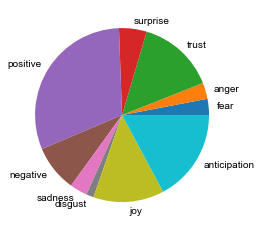

In [14]:
#create pie chart
plt.pie(aggr, labels = label) #, autopct='%.0f%%'
sns.set(rc={'figure.figsize':(20,10)})
plt.show()

Ordinare in ordine crescente per vedere qual è il sentimento piu ricorrente

In [60]:
#emotional dataframe sorted with most common words
df_em_mc = pd.DataFrame({'emotion': label, 'aggregation': aggr}).sort_values(by=['aggregation'],ascending=False)
df_em_mc.head()

,emotion,aggregation
4,positive,0.246
9,anticipation,0.137
2,trust,0.115
8,joy,0.105
5,negative,0.069


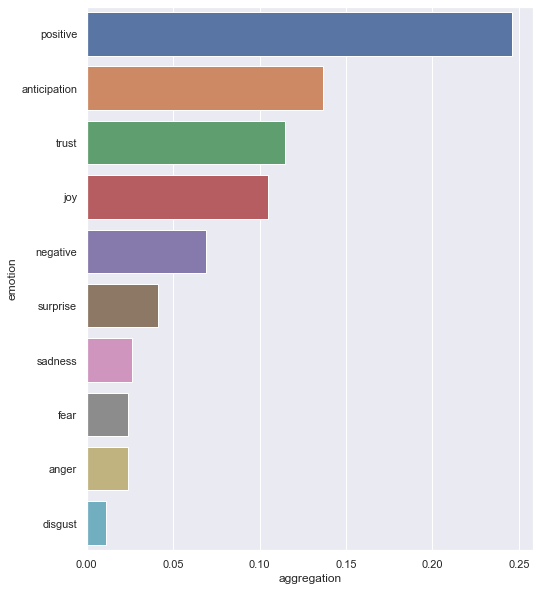

In [61]:
plt.figure(figsize=(8,10))
sns.barplot(y = 'emotion', x= 'aggregation', data = df_em_mc)
plt.show()

### La domanda adesso è: quali parole danno questo sentiment positivo? E quante volte compaiono?

Leggo il file creato da text_processing con le parole più comuni 

In [62]:
# df_mc = pd.read_csv('most_common.csv')
# df_mc = df_mc.drop(['Unnamed: 0'], axis =1)
# mc_list = df_mc['Word'].tolist()

In [11]:
df_counter = pd.read_csv('../dataframe/df_counter.csv').drop(['Unnamed: 0'], axis =1)
df_counter.columns = ['words', 'count']
df_counter

,words,count
0,adare,568
1,farm,40
2,support,303
3,limerickgoingforgold,13
4,gold,50
...,...,...
20130,uncut,1
20131,runmotivation,1
20132,parkun,1
20133,fitspo,1


Quali di queste parole si trovano nel nostro vocabolario?

In [3]:
#join together all the tweet in the column 'text1'
long_tweet = ",".join(df["text1"])

In [4]:
text = NRCLex(long_tweet)
word_dict = text.affect_dict #è un dizionario
sentiment_key = list(word_dict.keys())

In [5]:
df2 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in word_dict.items()]))
df2 = df2.fillna(0)
df2.head(10)

,farm,gold,team,ready,base,time,creep,vote,leave,beautiful,...,deny,scream,volunteers,steady,rock,bard,title,gap,decay,importance
0,anticipation,positive,trust,anticipation,trust,anticipation,negative,anger,negative,joy,...,anger,anger,trust,surprise,positive,positive,positive,negative,fear,anticipation
1,0,0,0,0,0,0,0,anticipation,sadness,positive,...,negative,disgust,0,trust,0,0,trust,0,negative,positive
2,0,0,0,0,0,0,0,joy,surprise,0,...,0,fear,0,0,0,0,0,0,sadness,0
3,0,0,0,0,0,0,0,negative,0,0,...,0,negative,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,positive,0,0,...,0,surprise,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,sadness,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,surprise,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,trust,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df3 = pd.DataFrame()
for i in label: new_df(i,df2,df3)
df3

,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
farm,0,0,0,0,0,0,0,0,0,1
gold,0,0,0,0,1,0,0,0,0,0
team,0,0,1,0,0,0,0,0,0,0
ready,0,0,0,0,0,0,0,0,0,1
base,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
bard,0,0,0,0,1,0,0,0,0,0
title,0,0,1,0,1,0,0,0,0,0
gap,0,0,0,0,0,1,0,0,0,0
decay,1,0,0,0,0,1,1,0,0,0


Creo una lista che contiene le liste delle emozioni

In [7]:
sentiment_list = []
for i in df3: sentiment_list.append(df3.loc[df3[i]!=0][i].reset_index()['index'].tolist())

In [8]:
fear_list = sentiment_list[0]
anger_list = sentiment_list[1]
trust_list = sentiment_list[2]
surprise_list = sentiment_list[3]
positive_list = sentiment_list[4]
negative_list = sentiment_list[5]
sadness_list = sentiment_list[6]
disgust_list = sentiment_list[7]
joy_list = sentiment_list[8]
anticipation_list = sentiment_list[9]


A questo punto ho df_counter = conteggio di tutte le parole e la lista dei sentimenti (pos, anticipation, ecc). Trasformo questa in un dataframe es df_pos (per positive list). 
In questo nuovo df devo aggiungere una nuova colonna chemi conteggia le parole. Tale conteggio è df_counter.
Infine ordino in ordine discendente. 

In [9]:
# df_pos = pd.DataFrame(positive_list, columns=['words'])
# df_pos.head()

In [12]:
df_fear = count_words(fear_list,df_counter)
df_fear

,words,count
387,lose,943
280,delay,243
2833,fire,185
1122,watch,174
3407,flood,152
...,...,...
3845,dread,1
3726,devil,1
3645,jeopardy,1
1257,unknown,1


In [13]:
df_pos = count_words(positive_list,df_counter)
df_pos

,words,count
1482,store,853
274,good,844
59,beautiful,743
1236,tree,501
448,gift,492
...,...,...
3067,abundance,1
1311,needle,1
2543,justifiable,1
3585,prop,1


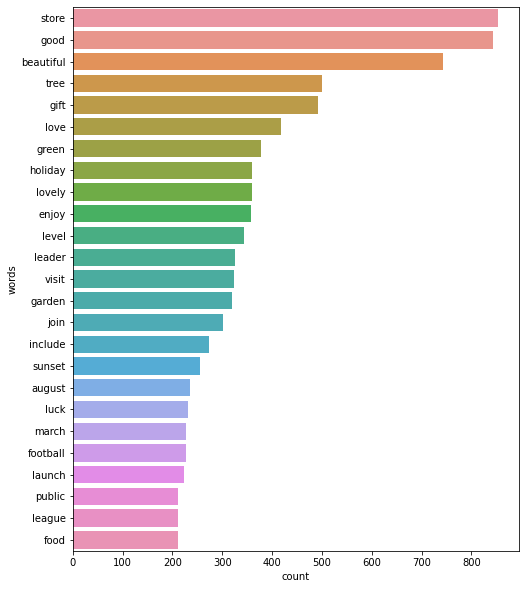

In [19]:
plt.figure(figsize=(8,10))
sns.barplot(y= 'words', x = 'count', data = df_pos[0:25]) #stampo le prime 25 parole che mi danno sentiment positive
plt.show()

## STEP 3: creare una nuvola in cui stampiamo le parole che compaiono di più in tutti i sentimenti